# Tutorial (Part 2): Learning Module
This tutorial should be run after the first tutorial (`Tutorial_1_Data_Handling.ipynb`).

This tutorial illustrates the usage of the `learning` module. The models are primarily defined in `SORBET/learning/models`; the core model is defined in `SORBET/learning/models/sorbet_gcn.py`. The doccstring is:
```Python
class GCNSorbetBase(BaseGraphModel):
    """GCN model with the following structure:
        - Linear Layers (`in_linear_channels`)
        - GCN Conv Layers (`conv_channels`)
        - Linear Layers (`embedding_linear_channels`)
        - Pooling Layer (default: global_mean)
        - Linear Layers (`out_linear_channels`)
    """

    def __init__(self,
            in_channel: int,
            in_linear_channels: List[int],
            conv_channels: List[int],
            embedding_linear_channels: List[int],
            out_linear_channels: List[int],
            block: str = 'dense', dropout: float = 0.3, batch_norm_args: dict = {'eps': 1e-5, 'momentum': 0.1},
            pooling_fn: pool = "global_mean", topk_pooling: int = None,
            loss_fn: torch.nn = BCEWithLogitsLoss, l1_penalty: Union[float, None] = None,
            random_seed: Optional[int] = None
            ):
        """
        Args:
            in_channel: size of input data (features)
            in_linear_channels: list of linear layer widths (`Input Layers`)
            conv_channels: list of conv layer widths (`Conv Layers`)
                block: block type, associated with the CGNConv layer in torch_geomtric.nn
            embedding_linear_channels: list of linear layer widths (`Embedding Layers`)
            out_linear_channels: list of linear layer widths (`Output Layers`)
            pooling_fn: the chosen pooling function. Applied between embedding_linear_channels and out_linear_channels.
                topk_pooling: boolean defining if the pooling function uses top-k pooling
            # Hyperparameters:
                dropout: dropout (applied to all layers)
                batch_norm_args: dictionary passed to batch normalization layer
            # Loss function choice: 
                loss_fn: a chosen loss function (def: torch.nn.BCEWithLogitsLoss)
                l1_penalty: define if an L1 penalty should be applied. Ignored if None or 0.
            random_seed: integer setting a random seed.
        """


```
(See `SORBET/learning/model/sorbet_gcn.py:27-64`)

**n.b.** A subsequent tutorial handles reasoning (`Tutorial_3_Reasoning.ipynb`). This module and the first module should be run prior to starting those modules.

In [26]:
import os
import csv, pickle
from tqdm.notebook import tqdm as tqdm
from functools import partial
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA

import numpy as np
import torch
import torch_geometric
import ray

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import SORBET
import SORBET.data_handling as data_handling
import SORBET.learning as learning

In [4]:
learning_output_dir = os.path.join("outputs", "tutorial", "learning")
if not os.path.exists(learning_output_dir):
    os.makedirs(learning_output_dir)

## Train a Single Model:
A funtion to train a single model is provided in `SORBET/training/train.py:32` using the `train_model` function.

```Python
def train_model(
        model_type, model_init_params: Dict[str, Any], 
        dataset: List[TorchOmicsDataset],
        optimizer_type: torch.optim = torch.optim.Adam,
        epochs: int = 200, learning_rate: float = 1e-3, batch_size: int = -1, validate_step: int = 2, restarts: int = 5,
        progressbar: bool = False, print_lvl: int = 0, tensorboard_dir: str = None, 
        device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), random_seed: float = None
        ) -> Tuple[Any, Tuple[np.ndarray, np.ndarray], Tuple[float, float], List[List[float]], List[Tuple[int, float]]]:
    """Trains a new model according to the chosen parameters.

    Args:
        model_type: the choice of model to train. See models/.
        model_init_params: model hyperparameters passed to initialize the model. See models/model_specification.py. 
        dataset: list of TorchOmicsDataset's to train on. Can be of length two or three.
            If length two, the first and last datasets are treated as the train and test sets, respectively.
            If length three, the second dataset is treated as the validation set. 
        optimizer_type: choice of optimizer
        epochs: maximum number of epochs
        learning_rate: learning rate hyperparameter
        batch_size: batch size for data iterator
        validate_step: number of epochs between evaluation of the validation set
        restarts: number of random models to train
        progressbar: whether to plot a progressbar tracking epochs
        print_lvl: display level. Higher integers correspond to more information printed.
        tensorboard_dir: output directory to put tensorboard results in
        device: device to train model on
        random_seed: set a random seed 
    
    Returns:
        Five results: the trained model, two lists of predictions and labels, AUROC and Average Precision,
            a list of lists of train losses (per epoch), and the validation loss (as a list of tuples of [epoch, validation loss])
    """
```
(See `SORBET/learning/train.py:32-63`)

In [5]:
labels_fpath = "data/tutorial/labels.csv"
root_fpath = os.path.abspath("./")
metadata_files = learning.make_subgraph_metadata("data/tutorial/processed_subgraphs/znormalized/")

In [104]:
# Create torch datasets for use with training SORBET models.
# learning.TorchOmicsDataset is a dataset sub-classing to the torch_geometric dataset
# See: SORBET/learning/dataset.py:11
train_graph_ids = [
    'run_5612_fov_1', 
    'run_5612_fov_2', 
    'run_5612_fov_3', 
    'run_5612_fov_4',
    'run_5612_fov_5',
    'run_5612_fov_6',
]

test_graph_ids = [
    'run_5612_fov_8', 
    'run_5612_fov_9',
    'run_5612_fov_7',
    'run_5612_fov_11'
]

train_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, train_graph_ids)
test_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, test_graph_ids)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.19it/s]
/home/joe/spatial_omics_reimp/SORBET/learning/plotting.py:382: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')


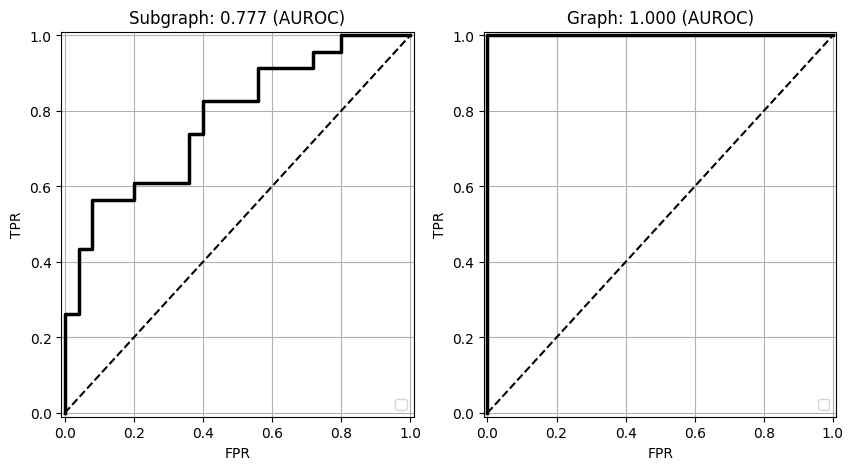

In [110]:
device = torch.device("cuda:2") # Choose specific GPU to train model:

model_structure = {
    'in_channel': 960,
    'random_seed': 50,
    'in_linear_channels': [96],
    'conv_channels': [96, 96, 96],
    'embedding_linear_channels': [192, 96],
    'out_linear_channels': [48],
    'dropout': 0.3,
    'pooling_fn': 'global_max',
    'l1_penalty': 0, # Ignored by model
    'topk_pooling': 0 # Ignored by model
}

params = {
    'epochs': 25, 
    'learning_rate': 0.03,
    'batch_size': 500, # Larger than max batch => Single Batch
    'restarts': 1,
    'validate_step': 48 # No cross validation necessary
}

model_type = learning.GCNSorbetBase

model, (preds, labels), scores, train_loss, val_loss  = learning.train_model(model_type,          # Model class as object. Typically, learning.GCNSorbetBase
                                                                             model_structure,     # Definition of model. Dictionary used to initialize class.
                                                                             [train_ds, test_ds], # Datasets. Can also pass a validation set. 
                                                                             **params,            # Training hyperpamaters, such as epochs
                                                                             print_lvl=0, device=device, progressbar=True, tensorboard_dir=None
                                                                            )

graph_ids, graph_labels, graph_preds = learning.predict_graphs_from_subgraphs(test_ds.processed_file_names, labels, preds)

fig, axes = plt.subplots(1,2,figsize=(10,5))

fpr, tpr, _ = roc_curve(labels, preds)
axes[0].plot(fpr, tpr, c='k', lw=2.5)
axes[0].set_title(f'Subgraph: {roc_auc_score(labels, preds):.3f} (AUROC)')

fpr, tpr, _ = roc_curve(graph_labels, graph_preds)
axes[1].plot(fpr, tpr, c='k', lw=2.5)
axes[1].set_title(f'Graph: {roc_auc_score(graph_labels, graph_preds):.3f} (AUROC)')
learning.format_roc_curve_axis(axes[0]); learning.format_roc_curve_axis(axes[1]) 
plt.show()

## Optimize Over Many Hyperparameter Choices:
A funtion to train over many hyperparameters is provided in `SORBET/training/hyperparameter_optimization.py:69` using the `hyperparameter_optimization` function. 

The optimization code can be for training hyperparameters, model structure, or both.

```Python
def hyperparameter_optimization(data_split: List[Tuple[list]], root_fpath: str, metadata_files: Any, input_data_dimension: int,  
        model_type: Any, model_hyperparameters: Dict[str, Any], set_model: bool = False, 
        tensorboard_dir: str = None, ray_run_config_kwargs: dict = {'verbose': 1}, 
        num_model_evals: int = 100, n_cpus: int = 12, n_gpus: int = 6, allow_fractional: float = 0, random_seed: Optional[int] = None) -> tune.ResultGrid:
    """The central function for hyperparameter optimization. Called to set-up and run Ray-tuning.

    Args:
        data_split: list of data splits. See train_utils.py for typical outputs
        root_fpath: the root of the data directories
        metadata_files: a SubgraphMetadata data class defining the data structure in root_fpath 
        input_data_dimension: input data dimension to models
        model_type: model class that optimization is applied to. See models/ 
        model_hyperparameters: dictionary of model hyperparameters used for defining the optimization framework.
        set_model: whether the structure of the model (n. layers, width of layers, etc) is pre-set. If not, ray optimizes over passed hyperparameters.
        tensorboard_dir: tensorboard filepath to save output values to
        ray_run_config_kwargs: additional keyword arguments passed to Ray.
        num_model_evals: number of sampled trials to run.
        n_cpus: number of CPUs used during optimzation
        n_gpus: number of GPUs used during evaluation. Assumes n_cpus >= n_gpus.
        allow_fractional: allow multiple models on each GPU.
        random_seed: a random seed to set for training all models

    Returns:
        A ray tune ResultGrid object summarizing the results of the experiment. 
    """
```
(See `SORBET/learning/hyperparameter_optimization.py:69-93`)

**n.b.** The code optimizes the Area under ROC curve for subgraphs **not** for graphs. 

In [72]:
labels_fpath = "data/tutorial/labels.csv"
root_fpath = os.path.abspath("./")
metadata_files = learning.make_subgraph_metadata("data/tutorial/processed_subgraphs/znormalized/")

In [111]:
# Create torch datasets for use with training SORBET models.
# learning.TorchOmicsDataset is a dataset sub-classing to the torch_geometric dataset
# See: SORBET/learning/dataset.py:11
train_graph_ids = [
    'run_5612_fov_1', 
    'run_5612_fov_2', 
    'run_5612_fov_3', 
    'run_5612_fov_4',
    'run_5612_fov_5',
    'run_5612_fov_6'
]

val_graph_ids = [
    'run_5612_fov_7',
    'run_5612_fov_11'
]

test_graph_ids = [
    'run_5612_fov_8', 
    'run_5612_fov_9',
]

### Optimize Only Hyperparameters (Fixed Model Structure):

In [89]:
# Example of how to optimize the number of epochs and learning rate:
hyperparam_search_space = {
    # Training Hyperparamters:
    "epochs": [10,25,50,100],      # Data passed as a list. The code will sample from the list.
    "learning_rate": [3e-5, 3e-2], # Data passed as a range. The code will infer sampling from this (log-)range.
    "batch_size": [100],
    "restarts": [1],
    # Model Hyperparameters:
    "in_linear_channels": [96], 
    "conv_channels": [96,96,96], 
    "embedding_linear_channels": [192,96], 
    "out_linear_channels": [48],
    "dropout": [0.3], 
    "l1_penalty": [0],
    "topk_pooling": [0.0],
    "pooling_fn": ["global_max"]
}
model_type = learning.GCNSorbetBase

input_dims = 960 # Dimension at each node
random_seed = 50

n_model_evaludations = 25


# Controls visible GPUs
# Modify to take advantage of available resources
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 
n_gpus = 4
n_cpus = 2 * n_gpus

# Requires a list of lists. 
# Each sub-list should be of length three corresponding to the train, validate and test
# The graph IDs, not TorchOmicsDatasets, should be passed
data_split = [(train_graph_ids, val_graph_ids, test_graph_ids)] 

results = learning.hyperparameter_optimization(
    data_split, root_fpath, metadata_files, # Data split for analysis and location of data
    input_dims, model_type,                 # Definition of model for analysis
    hyperparam_search_space,                # Passing the search space for hyperparameter optimization
    set_model = True,                       # set_model is True to not optimize model structure
    num_model_evals=n_model_evaludations,   # Number of random models to evaluate
    n_cpus = n_cpus, n_gpus = n_gpus, allow_fractional = 1.0, 
    random_seed = random_seed
)

2025-08-05 22:56:52,846	INFO tune.py:1148 -- Total run time: 63.68 seconds (63.64 seconds for the tuning loop).


We can then plot the performance of the model across hyperparameters using `learning.plot_hyperparameter_performance`. 

Axes(0.125,0.11;0.352273x0.77)
config/learning_rate
Axes(0.547727,0.11;0.352273x0.77)
config/epochs


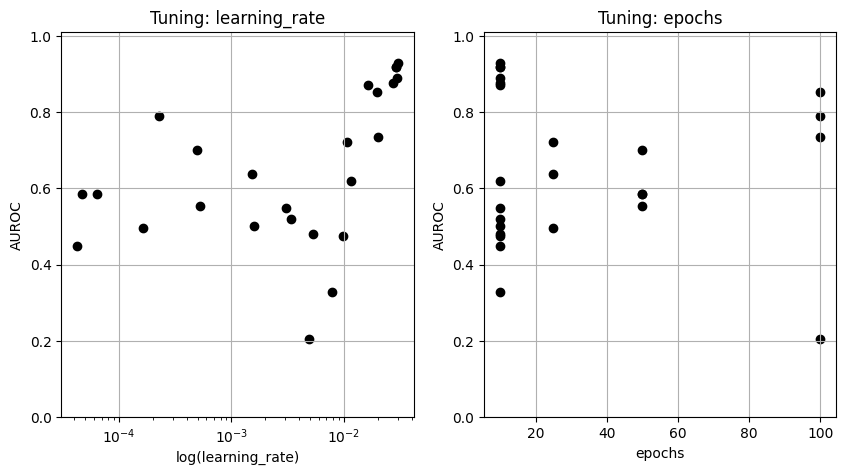

In [90]:
learning.plot_hyperparameter_performance(results, ["learning_rate", "epochs"], ncols=2); plt.show()

### Optimize Model Structure:

In [112]:
# Example of how to optimize the number of epochs and learning rate:
hyperparam_search_space = {
    # Training Hyperparamters:
    "epochs": [10,25,50,100],      # Data passed as a list. The code will sample from the list.
    "learning_rate": [3e-5, 3e-2], # Data passed as a range. The code will infer sampling from this (log-)range.
    "batch_size": [100],
    "restarts": [1],
    # Model Hyperparameters:
    # Channel sampling has a standard structure:
    # [`min num. of layers`, `max num. of layers`, [sampling definition]]
    # The sampling definition defines widths. Can be a range (two numbers) or a list (1 or 3+ numbers).
    "in_linear_channels": [1,3,[48,96]],            # Variable layers and range of widths
    "conv_channels": [3,3,[96]],                    # Fixed number of layers and fixed widths
    "embedding_linear_channels": [1,3,[48,96,192]], # Variable layers and fixed sample of widths
    "out_linear_channels": [1,1,[24,48]],           # Fixed number of layers and range of widths
    "dropout": [0.1, 0.5],                          # Can vary the value of dropout
    "l1_penalty": [0],
    "topk_pooling": [0.0],
    "pooling_fn": ["global_max"]
}
model_type = learning.GCNSorbetBase

input_dims = 960 # Dimension at each node
random_seed = 50

n_model_evaludations = 100


# Controls visible GPUs
# Modify to take advantage of available resources
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 
n_gpus = 4
n_cpus = 2 * n_gpus

# Requires a list of lists. 
# Each sub-list should be of length three corresponding to the train, validate and test
# The graph IDs, not TorchOmicsDatasets, should be passed
data_split = [(train_graph_ids, val_graph_ids, test_graph_ids)] 

results = learning.hyperparameter_optimization(
    data_split, root_fpath, metadata_files, # Data split for analysis and location of data
    input_dims, model_type,                 # Definition of model for analysis
    hyperparam_search_space,                # Passing the search space for hyperparameter optimization
    set_model = False,                      # set_model set to False in order to evaluate over hyperparameters
    num_model_evals=n_model_evaludations,   # Number of random models to evaluate
    n_cpus = n_cpus, n_gpus = n_gpus, allow_fractional = 1.0, 
    random_seed = random_seed
)

2025-08-05 23:18:46,413	INFO tune.py:1148 -- Total run time: 342.83 seconds (342.76 seconds for the tuning loop).


Axes(0.125,0.11;0.352273x0.77)
config/learning_rate
Axes(0.547727,0.11;0.352273x0.77)
config/epochs


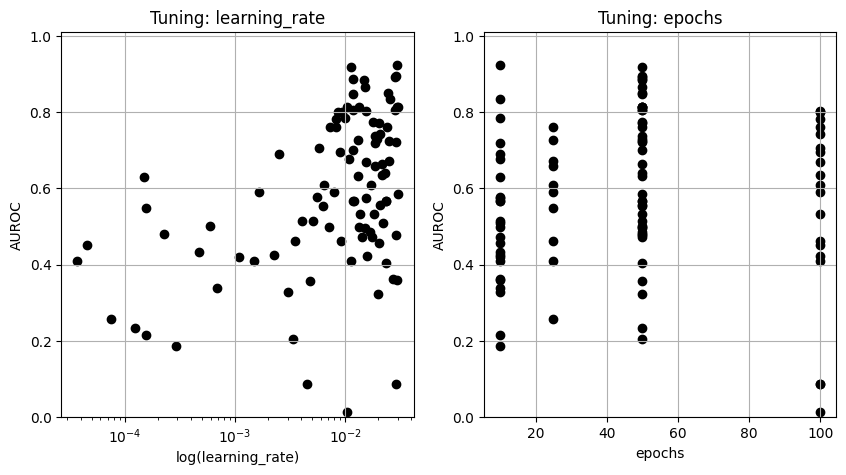

In [113]:
learning.plot_hyperparameter_performance(results, ["learning_rate", "epochs"], ncols=2); plt.show()

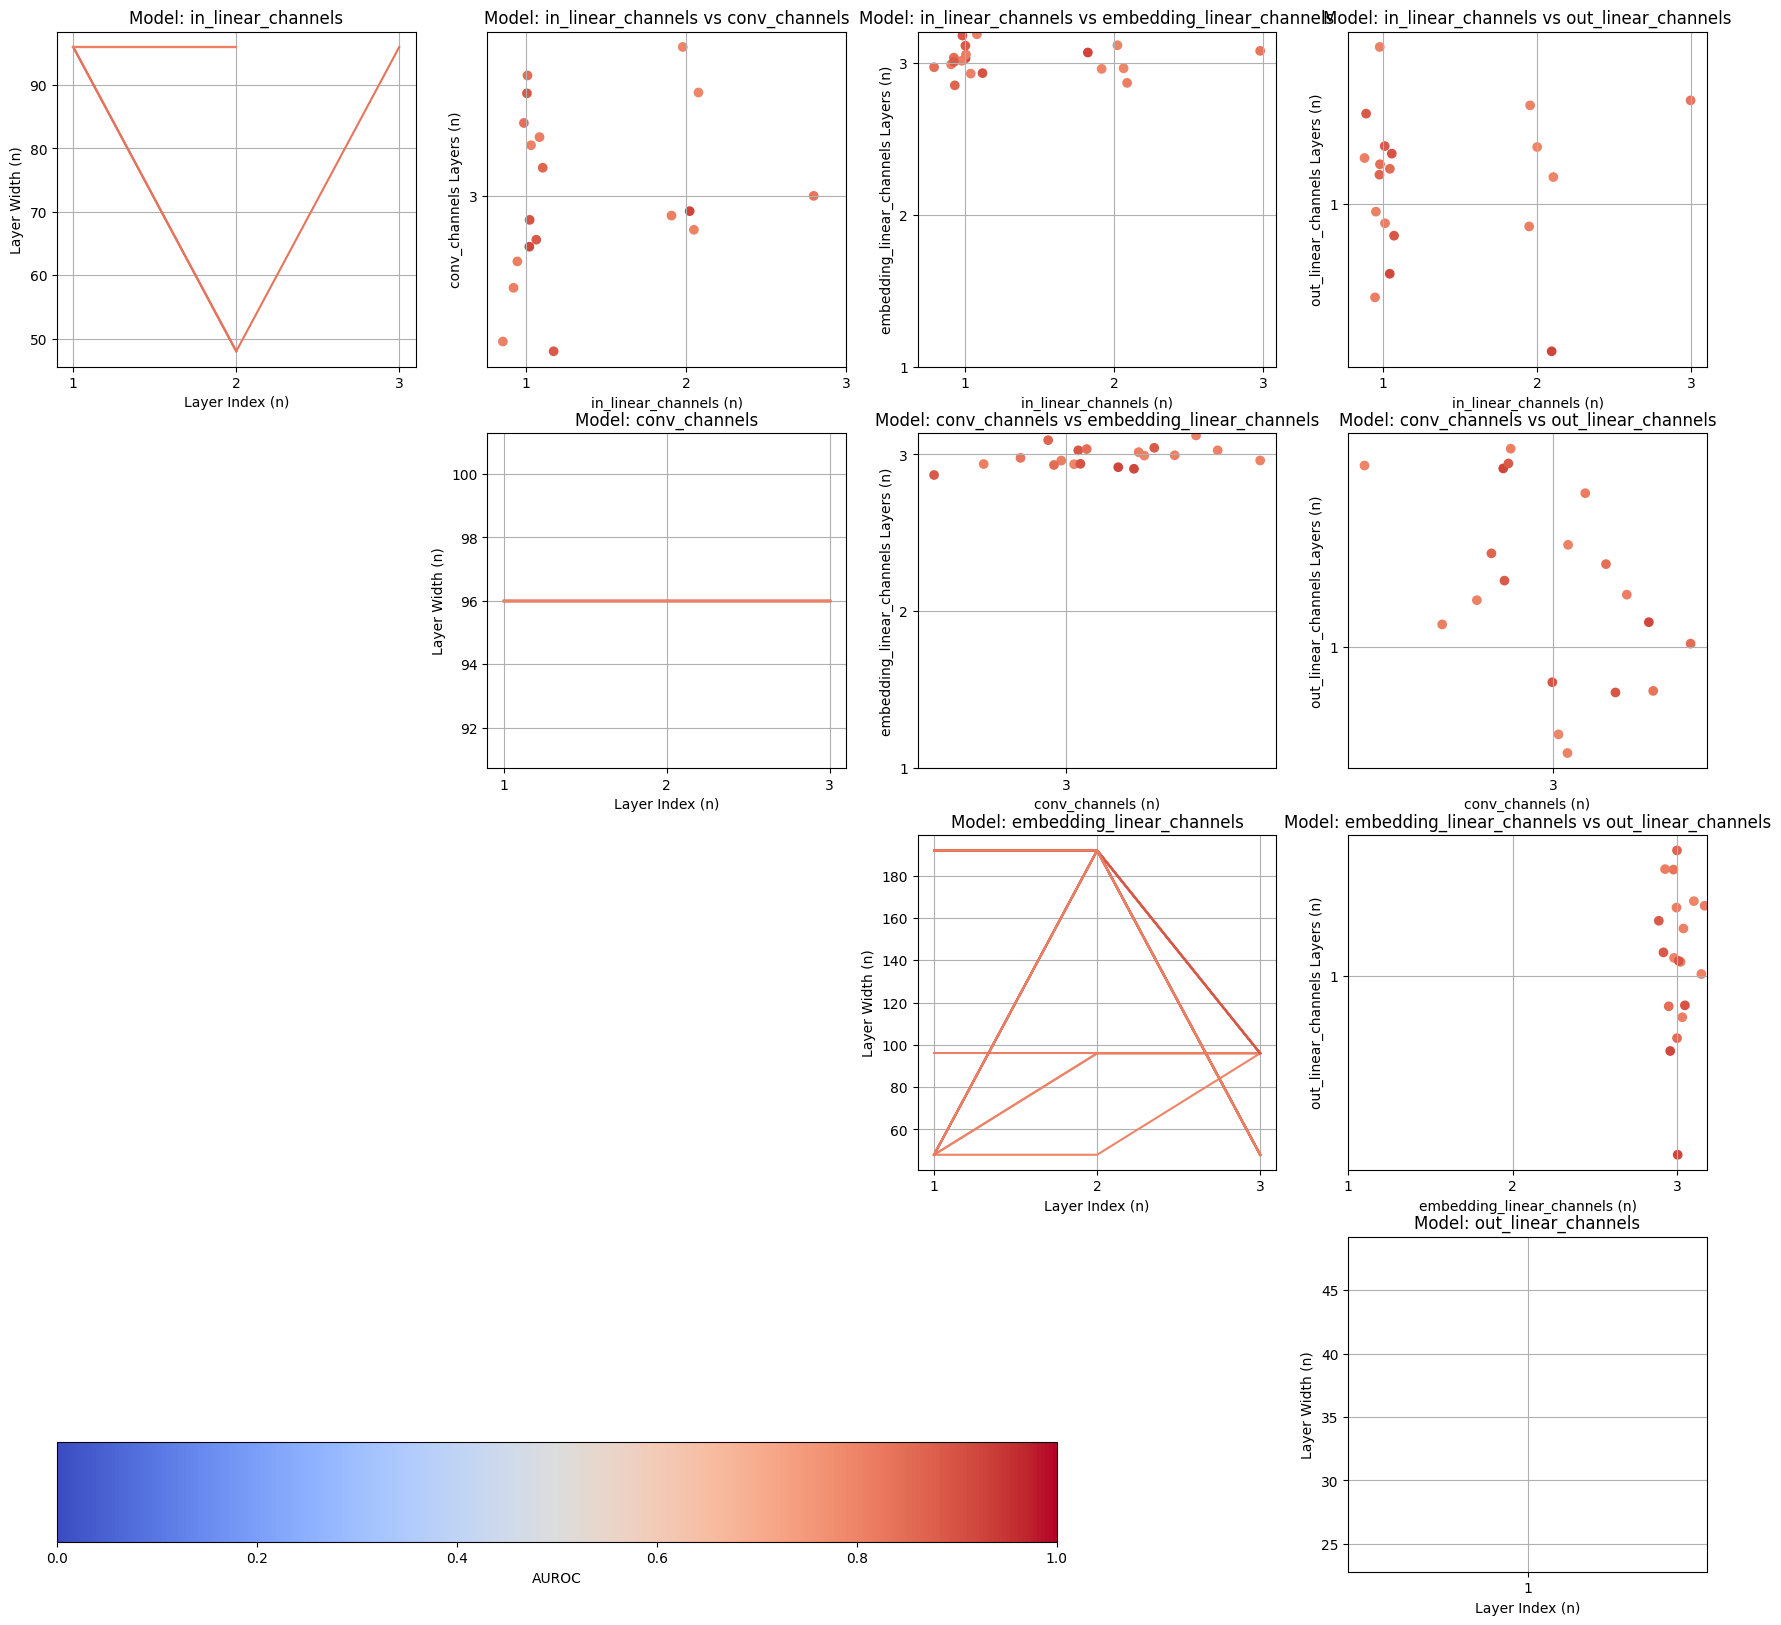

In [116]:
learning.plot_serializable_model_performance(results, 
                                             # A list of model parameters to consider. 
                                             # Can be useful to exclude parameters that were fixed during experiments
                                             ["in_linear_channels", "conv_channels", "embedding_linear_channels", "out_linear_channels"], 
                                             learning.GCNSorbetBase, # Model Type 
                                             auroc_cutoff=0.8        # Exclude models below a specific threshold 
                                            ); plt.show()


We can extract the best result from the Ray results object using the built-in `get_best_result` object. This can then be converted to an input to `learning.train_model` using the function `learning.get_model_and_training_specifications`.

In [128]:
best_result = results.get_best_result(metric = 'auroc', mode = 'max')
print("Best result: ", best_result)
print("Config: ", best_result.config)

Best result:  Result(
  metrics={'auroc': 0.9238095238095239, 'done': True, 'trial_id': '7eb23449', 'experiment_tag': '23_batch_size=100,conv_channels_0=96,conv_channels_1=96,conv_channels_2=96,conv_channels_n_layers=3,dropout=0.2722,embedding_linear_channels_0=48,embedding_linear_channels_1=192,embedding_linear_channels_2=96,embedding_linear_channels_n_layers=3,epochs=10,in_linear_channels_0=96,in_linear_channels_1=48,in_linear_channels_n_layers=2,l1_penalty=0,learning_rate=0.0297,out_linear_channels_0=24,out_linear_channels_n_layers=1,pooling_fn=global_max,restarts=1,topk_pooling=0.0000'},
  path='/home/user/ray_results/objective_2025-08-05_23-13-03/objective_7eb23449_23_batch_size=100,conv_channels_0=96,conv_channels_1=96,conv_channels_2=96,conv_channels_n_layers=3,dropout=0.2_2025-08-05_23-13-59',
  checkpoint=None
)
Config:  {'in_linear_channels_n_layers': 2, 'in_linear_channels_0': 96, 'in_linear_channels_1': 48, 'conv_channels_n_layers': 3, 'conv_channels_0': 96, 'conv_channels_

In [131]:
train_params, model_structure = learning.get_model_and_training_specifications(
    best_result.config, # Config derived from the Ray tune results
    model_type, input_dims, random_seed
)

print("Identified Model Structure: ")
print(model_structure)
print("Identified Hyperparameters: ")
print(train_params)

Identified Model Structure: 
{'in_channel': 960, 'random_seed': 50, 'in_linear_channels': [96, 48], 'conv_channels': [96, 96, 96], 'embedding_linear_channels': [48, 192, 96], 'out_linear_channels': [24], 'dropout': 0.2721890779102155, 'pooling_fn': 'global_max', 'l1_penalty': 0, 'topk_pooling': 0.0}
Identified Hyperparameters: 
{'epochs': 10, 'learning_rate': 0.02965881347204247, 'batch_size': 100, 'restarts': 1}


# k-Fold Cross Validation
Assess the model performance using k-Fold Cross Validation.

Here, we use methods developed to complete a stratified split of graphs (**not** subgraphs) that retains positive and negative samples in each fold (important for small sample sizes. Most of the tools helpful for this analysis are contained in `learning/train_utils.py`.

In [117]:
labels_fpath = "data/tutorial/labels.csv"
root_fpath = os.path.abspath("./")
metadata_files = learning.make_subgraph_metadata("data/tutorial/processed_subgraphs/znormalized/")

In [122]:
number_folds = 4 # K. 
data_split =  list(learning.stratified_kfold_split(
    labels_fpath,   # Filepath with graphs. Can also pass as dictionary of graph:label pairs                                                
    number_folds,   # K in k-fold.                                                
    include_validation=True, as_fpath=True                                                  
))

_example_fold = data_split[0]
print("Example Fold:")
print(f'Train IDs: {" ".join(_example_fold[0])}')
print(f'Val IDs: {" ".join(_example_fold[1])}')
print(f'Test IDs: {" ".join(_example_fold[2])}')

Example Fold:
Train IDs: run_5612_fov_2 run_5612_fov_5 run_5612_fov_8 run_5612_fov_6
Val IDs: run_5612_fov_7 run_5612_fov_11 run_5612_fov_9
Test IDs: run_5612_fov_3 run_5612_fov_1 run_5612_fov_4


In [163]:
device = torch.device("cuda:2") # Choose specific GPU to train model:

# Example of how to optimize the number of epochs and learning rate:
hyperparam_search_space = {
    # Training Hyperparamters:
    "epochs": [5,10,25], 
    "learning_rate": [3e-4, 3e-3, 3e-2], 
    "batch_size": [100],
    "restarts": [1],
    # Model Hyperparameters:
    "in_linear_channels": [1,3,[24,48,96]], 
    "conv_channels": [3,3,[24,48,96]], 
    "embedding_linear_channels": [1,3,[48,96,192]], 
    "out_linear_channels": [1,3,[24,48,96]],
    "dropout": [0.3], 
    "l1_penalty": [0],
    "topk_pooling": [0.0],
    "pooling_fn": ["global_max"]
}
model_type = learning.GCNSorbetBase

input_dims = 960 # Dimension at each node
random_seed = 50

n_model_evaludations = 100

# Controls visible GPUs
# Modify to take advantage of available resources
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 
n_gpus = 4
n_cpus = 2 * n_gpus

aurocs = list()
predictions = list()

for train_set, val_set, test_set in data_split:
    results = learning.hyperparameter_optimization(
        [[train_set, val_set, test_set]], root_fpath, metadata_files, input_dims, model_type, 
        hyperparam_search_space,
        set_model = False, num_model_evals = n_model_evaludations, 
        n_cpus = n_cpus, n_gpus = n_gpus, allow_fractional = 1.0,
        random_seed = 50
    )

    best_result = results.get_best_result(metric = 'auroc', mode = 'max')
    train_params, model_structure = learning.get_model_and_training_specifications(
        best_result.config, # Config derived from the Ray tune results
        model_type, input_dims, random_seed
    )

    # Re-train model with optimal parameters:
    train_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, [*train_set, *val_set])
    test_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, test_set)
    train_params['epochs'] = 25
    train_params['learning_rate'] = 3e-2
    
    model, (preds, labels), scores, train_loss, val_loss  = learning.train_model(
        model_type, model_structure, [train_ds, test_ds], **train_params,  
        print_lvl=0, device=device, progressbar=False, tensorboard_dir=None
    )

    graph_ids, graph_labels, graph_preds = learning.predict_graphs_from_subgraphs(test_ds.processed_file_names, labels, preds)

    print(roc_auc_score(graph_labels, graph_preds))
    aurocs.append((roc_auc_score(graph_labels, graph_preds), train_params, model_structure))
    predictions.append((graph_labels, graph_preds))

2025-08-06 03:45:38,209	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
(bundle_reservation_check_func pid=119980) Traceback (most recent call last):
(bundle_reservation_check_func pid=119980)   File "python/ray/_raylet.pyx", line 1578, in ray._raylet.execute_task
(bundle_reservation_check_func pid=119980)   File "python/ray/_raylet.pyx", line 3710, in ray._raylet.CoreWorker.store_task_outputs
(bundle_reservation_check_func pid=119980)   File "/usr/local/lib/python3.10/site-packages/ray/_private/serialization.py", line 468, in serialize
(bundle_reservation_check_func pid=119980)     return self._serialize_to_msgpack(value)
(bundle_reservation_check_func pid=119980)   File "/usr/local/lib/python3.10/site-packages/ray/_private/serialization.py", line 446, in _serialize_to_msgpack
(bundle_reservation_check_func pid=119980)     pickle5_s

1.0


In [164]:
aurocs

[(1.0,
  {'epochs': 25, 'learning_rate': 0.03, 'batch_size': 100, 'restarts': 1},
  {'in_channel': 960,
   'random_seed': 50,
   'in_linear_channels': [48],
   'conv_channels': [96, 48, 24],
   'embedding_linear_channels': [96],
   'out_linear_channels': [96],
   'dropout': 0.3,
   'pooling_fn': 'global_max',
   'l1_penalty': 0,
   'topk_pooling': 0.0}),
 (1.0,
  {'epochs': 25, 'learning_rate': 0.03, 'batch_size': 100, 'restarts': 1},
  {'in_channel': 960,
   'random_seed': 50,
   'in_linear_channels': [48],
   'conv_channels': [48, 96, 24],
   'embedding_linear_channels': [192, 96, 192],
   'out_linear_channels': [96, 48],
   'dropout': 0.3,
   'pooling_fn': 'global_max',
   'l1_penalty': 0,
   'topk_pooling': 0.0}),
 (1.0,
  {'epochs': 25, 'learning_rate': 0.03, 'batch_size': 100, 'restarts': 1},
  {'in_channel': 960,
   'random_seed': 50,
   'in_linear_channels': [96, 96],
   'conv_channels': [24, 24, 48],
   'embedding_linear_channels': [96, 96, 48],
   'out_linear_channels': [48, 

Average AUROC: 1.000


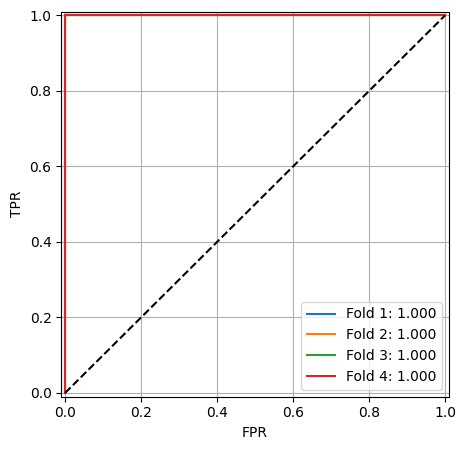

In [166]:
fig, ax = plt.subplots(figsize=(5,5))
for idx, (labs, preds) in enumerate(predictions):
    fpr, tpr, _ = roc_curve(labs, preds)
    ax.plot(fpr, tpr, label=f'Fold {idx + 1}: {roc_auc_score(labs, preds):.3f}')
learning.format_roc_curve_axis(ax)

print(f'Average AUROC: {np.mean([t[0] for t in aurocs]):.3f}')
